In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip -uq '/content/drive/MyDrive/Colab Notebooks/HURJC-main.zip'

In [3]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
import os, warnings
from matplotlib import gridspec
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow.keras.layers.experimental.preprocessing as preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import ModelCheckpoint
import math
import skimage.exposure
from skimage.transform import resize

from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dropout
import glob
import seaborn as sns
import cv2
from skimage.color import rgb2gray

%matplotlib inline

In [4]:
labels_df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Copia de calcific_tendinopathy_ddbb_pruebas.xlsx')
#labels_df = pd.read_excel('/content/HURJC-main/calcific_tendinopathy_ddbb (4).xlsx')

In [5]:
labels = np.array(labels_df['calcium'].tolist())
print(labels)

[1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1]


In [6]:
labels_df.head(105)

,image,calcium,pat_id,type,localization
0,001065097F_001.png,1,1065097F,2,supraespinoso
1,001065097F_002.png,1,1065097F,2,supraespinoso
2,001079917Z_001.png,1,1079917Z,1,supraespinoso e infraespinoso
3,001079917Z_002.png,1,1079917Z,1,supraespinoso e infraespinoso
4,001120686Z_001.png,1,1120686Z,2,infraespinoso
...,...,...,...,...,...
95,0080723M_002.png,1,80723M,2,supraespinoso
96,0094847_001.png,0,94847,-1,NaN
97,00RCVHD_001.png,0,RCVHD,-1,NaN
98,00RCV_001.png,1,RCV,3,supraespinoso


In [7]:
labels_df.describe()

,calcium,type
count,100.000000,100.000000
mean,0.780000,1.550000
std,0.416333,1.635311
min,0.000000,-1.000000
25%,1.000000,1.000000
50%,1.000000,2.000000
75%,1.000000,3.000000
max,1.000000,4.000000


In [8]:
files = sorted(glob.glob('/content/HURJC-main/database/*.png'))

In [9]:
images = []
for path in files:
  img = io.imread(path)
  img_rgb2gray=rgb2gray(img)
  images.append(resize(img_rgb2gray,(224,224,3)))

In [10]:
images = np.array(images)

In [11]:
images.shape

(100, 224, 224, 3)

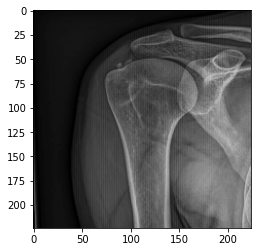

In [12]:
plt.imshow(images[0])

In [13]:
print(labels)
print(labels.shape)

[1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1]
(100,)


In [14]:
#indicies = np.random.permutation(100) #Aleatorización de las imágenes
#train_true_idx, test_true_idx = indicies[:90], indicies[90:] #90 imágenes de 1s en train, y 10 imágenes de 1s en test, todas ellas elegidas aleatoriamente de la primera mitad (100) de 1s

#train_false_idx, test_false_idx = indicies[:90] + 100, indicies[90:] + 100 #90 imágenes de 0s en train, y 10 imágenes de 0s en test, todas ellas elegidas aleatoriamente de la segunda mitad (100) de 0s
#train_idx, test_idx = train_true_idx, test_true_idx #Juntamos los 0s y los 1s en sus grupos correspondientes (train y test)

train_validationX, train_validationY = images[:90], labels[:90] #Primer conjunto que contiene las imágenes de train y validación
testX, testY = images[90:], labels[90:] #Segundo conjunto que contiene las imágenes de test

print(train_validationX.shape, testX.shape)
print(train_validationY.shape, testY.shape)

(90, 224, 224, 3) (10, 224, 224, 3)
(90,) (10,)


In [15]:
trainX, validX, trainY, validY = train_test_split(train_validationX, train_validationY, test_size=0.2, random_state=0)

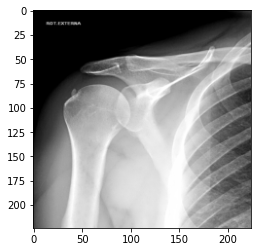

In [16]:
plt.imshow(trainX[0])

In [17]:
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from s

In [18]:
train_image_data = ImageDataGenerator(
    zoom_range=0.05, #Zoom aleatorio sobre las imágenes
    #rotation_range=180, #Rotación de las imágenes
    width_shift_range=0.05, #Fracción de anchura total
    height_shift_range=0.05, #Fracción de altura total
    horizontal_flip=True, #Voltear horizontalmente
    #vertical_flip=True, #Voltear verticalmente
    #fill_mode='constant', #Tipo de relleno para los inputs que están fuera de los límites
    #cval=0 #Valor usado para rellenar los inputs fuera de los límites
    )
validation_image_data = ImageDataGenerator(
    zoom_range=0.05, #Zoom aleatorio sobre las imágenes
    #rotation_range=180, #Rotación de las imágenes
    width_shift_range=0.05, #Fracción de anchura total
    height_shift_range=0.05, #Fracción de altura total
    horizontal_flip=True, #Voltear horizontalmente
    #vertical_flip=True, #Voltear verticalmente
    #fill_mode='constant', #Tipo de relleno para los inputs que están fuera de los límites
    #cval=0 #Valor usado para rellenar los inputs fuera de los límites
    )
test_datagen = ImageDataGenerator(rescale=1./255)

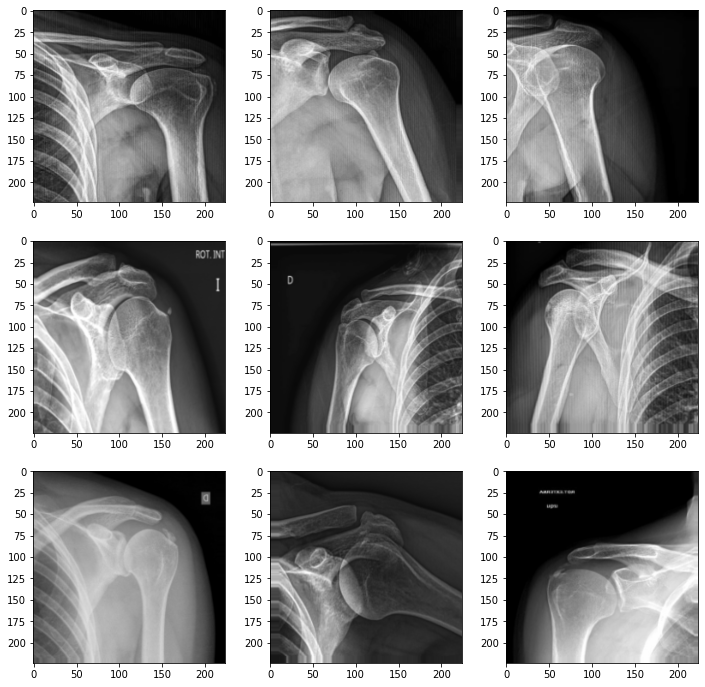

In [19]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_image_data.flow(trainX, trainY, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i],cmap='gray')
    plt.show()
    break

In [20]:
from sklearn.metrics import classification_report
def check_accuracy(model, setX, actual, print_images=True): 
    predicted = np.array([int(x[0] > 0.5) for x in model.predict(setX)]) #Guardamos en la variable predicted la predicción (0 o 1) de nuestro modelo sobre las imágenes
    if print_images: #Generamos las imágenes con la etiqueta predicha y la verdadera
        rows = math.ceil(len(predicted)/10.) 
        plt.figure(figsize=(20, 3 * rows))
        for i in range(len(predicted)): 
            plt.subplot(rows, 10, i+1)
            plt.imshow(setX[i])
            plt.title("pred "+str(predicted[i])+" actual "+str(actual[i]))
    target_names = ['class 0', 'class 1'] 
    print(classification_report(actual, predicted, target_names=target_names))    
    confusion = confusion_matrix(actual, predicted) #Guardamos en confusion la matriz de confusión generada
    tn, fp, fn, tp = confusion.ravel() #Asignamos cada elemento de la matriz
    print("True positive:", tp, ", True negative:", tn,
          ", False positive:", fp, ", False negative:", fn)

    print("Total accuracy:", np.sum(predicted==actual) / len(predicted) * 100., "%") 
    return (tn, fp, fn, tp)

In [21]:
from tensorflow.keras.applications import VGG16
inp = layers.Input(shape=(224, 224, 3))
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=inp,
                   input_shape=(224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [22]:
flat = layers.Flatten()
dropped = layers.Dropout(0.3)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
BN = layers.BatchNormalization()

fc1 = layers.Dense(256, activation='relu', name='dense_1')
prediction = layers.Dense(1, activation='sigmoid', name='output')
for layr in base_model.layers:
    if ('flatten_1' in layr.name):

        layr.trainable = True
    else:
        layr.trainable = False

In [23]:
block5_pool = base_model.get_layer('block5_pool')

x = flat(block5_pool.output)
x = fc1(x)
x = BN(x)
x = dropped(x)
x = prediction(x)

In [24]:
model = tf.keras.models.Model(inputs = inp, outputs = x)
model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [25]:
'''
train_batch_size = 12
val_batch_size = 7

train_generator = train_image_data.flow(
    trainX,
    trainY,
    batch_size=train_batch_size)

validation_generator = validation_image_data.flow( 
    validX,
    validY,
    batch_size=val_batch_size)
'''

bgen_train = BalancedDataGenerator(trainX, trainY, train_image_data, batch_size=9)
bgen_val = BalancedDataGenerator(validX, validY, validation_image_data, batch_size=9)
steps_per_epoch = bgen_train.steps_per_epoch
validation_steps = bgen_val.steps_per_epoch

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [26]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(trainY), 
                trainY) 
class_weights = {i : class_weights[i] for i in range(2)}
class_weights

{0: 2.4, 1: 0.631578947368421}

In [27]:
from sklearn.utils import class_weight
#steps_per_epoch = train_generator.n // train_batch_size
#validation_steps = validation_generator.n // val_batch_size

history = model.fit(bgen_train,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=bgen_val,
                    validation_steps=validation_steps,
                    #callbacks=model_checkpoint_callback,
                    #class_weight=class_weights,
                    epochs=100)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/100
12/12 [==============================] - 6s 253ms/step - loss: 0.6776 - binary_accuracy: 0.6990 - val_loss: 0.7106 - val_binary_accuracy: 0.8235
Epoch 2/100
12/12 [==============================] - 1s 125ms/step - loss: 0.2886 - binary_accuracy: 0.8781 - val_loss: 0.6605 - val_binary_accuracy: 0.6667
Epoch 3/100
12/12 [==============================] - 1s 128ms/step - loss: 0.1535 - binary_accuracy: 0.9063 - val_loss: 0.5213 - val_binary_accuracy: 0.7059
Epoch 4/100
12/12 [==============================] - 2s 125ms/step - loss: 0.1482 - binary_accuracy: 0.9616 - val_loss: 0.6175 - val_binary_accuracy: 0.8235
Epoch 5/100
12/12 [==============================] - 1s 124ms/step - loss: 0.1107 - binary_accuracy: 0.9870 - val_loss: 0.4978 - val_binary_accuracy: 0.7778
Epoch 6/100
12/12 [==============================] - 1s 123ms/step - loss: 0.0896 - binary_accuracy: 0.9721 - val_loss: 0.5973 - val_binary_accuracy: 0.8235
Epoch 7/100
12/12 [==============================] - 1s 12

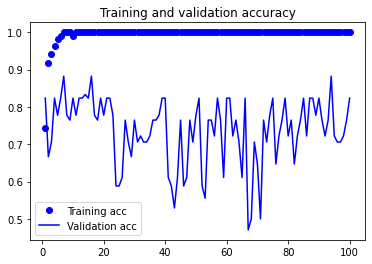

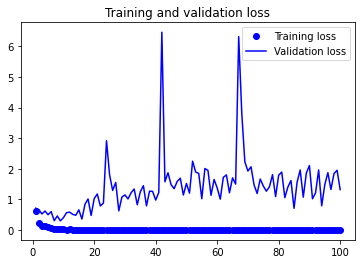

In [28]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()
plt.show()

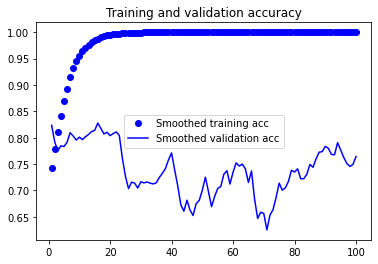

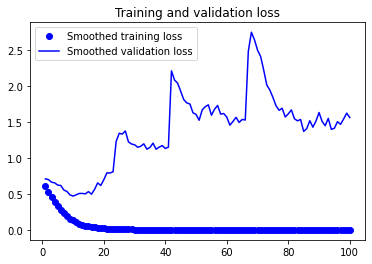

In [29]:
def smooth_curve(points, factor=0.8): 
  smoothed_points = []
  for point in points:
      if smoothed_points:
          previous = smoothed_points[-1]
          smoothed_points.append(previous * factor + point * (1 - factor))
      else: 
          smoothed_points.append(point)
  return smoothed_points
plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy') 
plt.legend()
plt.figure()
plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss') 
plt.legend()
plt.show()

              precision    recall  f1-score   support

     class 0       0.29      1.00      0.44         2
     class 1       1.00      0.38      0.55         8

    accuracy                           0.50        10
   macro avg       0.64      0.69      0.49        10
weighted avg       0.86      0.50      0.53        10

True positive: 3 , True negative: 2 , False positive: 0 , False negative: 5
Total accuracy: 50.0 %


(2, 0, 5, 3)

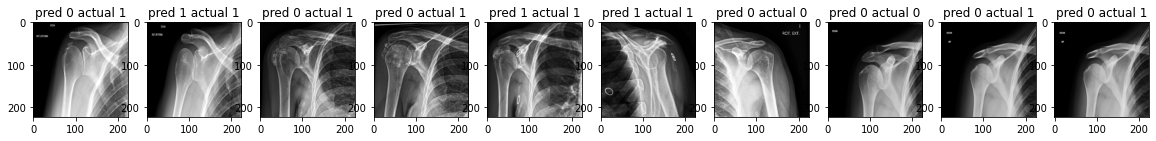

In [30]:
check_accuracy(model, testX, testY)

GRAD-CAM VGG16

In [31]:
from tensorflow.keras.applications import VGG16
from PIL import Image
import matplotlib.cm as cm

scale=1
img_size  = (224,224,3)

model = model

preprocess_input   = keras.applications.vgg16.preprocess_input
decode_predictions = keras.applications.vgg16.decode_predictions

last_conv_layer_name   = 'block5_conv3'
classifier_layer_names =  ['block5_pool', 'flatten']



In [32]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [33]:
img_array =  get_img_array(img_path = "/content/HURJC-main/database/001661043F_002.png",size = (224,224))

In [34]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    
    # Modelo que mapea la imagen de entrada a la capa convolucional última,
    # donde se calculará la activación
    last_conv_layer  = model.get_layer(last_conv_layer_name)
    conv_model       = keras.Model(model.inputs, last_conv_layer.output)

    # Modelo que mapea las activaciones a la salida final
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)
    
    # Cálculo del gradiente la salida  del modelo clasificador respecto a     
    with tf.GradientTape() as tape:
        
        # Calcula activacion del modelo base convolucional
        last_conv_layer_output = conv_model(img_array)
        tape.watch(last_conv_layer_output)
        
        # Calcula la predicción con modelo clasificador, para la clase mas probable
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        print(top_pred_index)
        top_class_channel = preds[:, top_pred_index]

    # Obtenemos el gradiente en la capa final clasificadora con respecto a
    # la salida del modelo base convolucional
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # Vector de pesos: medias del gradiente por capas,
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # salida de la última capa convolucional
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    
    # saliencia es la respuesta promedio de la última capa convolucional
    saliency = np.mean(last_conv_layer_output, axis=-1)
    saliency = np.maximum(saliency, 0) / np.max(saliency)
    
    # Multiplicación de cada canal por el vector de pesos
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
        
    # Heatmap: promedio de cada canal por su peso
    grad_cam = np.mean(last_conv_layer_output, axis=-1)
    grad_cam = np.maximum(grad_cam, 0) / np.max(grad_cam)
    
    return grad_cam, saliency

In [35]:
grad_cam, saliency = make_gradcam_heatmap(img_array, 
                                          model, 
                                          last_conv_layer_name, 
                                          classifier_layer_names)

tf.Tensor(10530, shape=(), dtype=int64)


In [36]:
def show_hotmap (img, heatmap, title='Heatmap', alpha=0.6, cmap='jet', axisOnOff='off'):
    '''
    img     :    Image
    heatmap :    2d narray
    '''
    resized_heatmap=resize(heatmap, img.size)
    
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.imshow(resized_heatmap, alpha=alpha, cmap=cmap)
    plt.axis(axisOnOff)
    plt.title(title)
    plt.show()

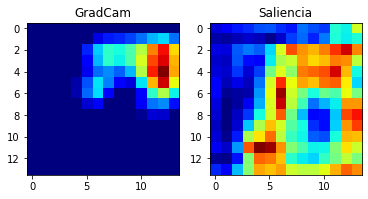

In [37]:
plt.subplot(121)
plt.imshow(grad_cam, 'jet')
plt.title('GradCam')
plt.subplot(122)
plt.imshow(saliency, 'jet')
plt.title('Saliencia')
plt.show()

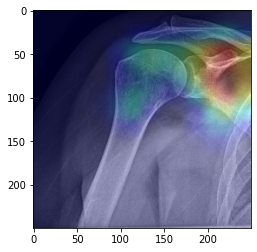

In [38]:
img = keras.preprocessing.image.load_img("/content/HURJC-main/database/001661043F_002.png")
img = keras.preprocessing.image.img_to_array(img)
img_a=np.array(img)
img = resize(img_a,(250,250))

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * grad_cam)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
#superimposed_img_res=resize(superimposed_img,(250,250))

plt.imshow(superimposed_img)

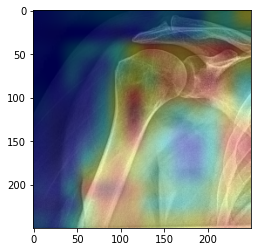

In [39]:
img = keras.preprocessing.image.load_img("/content/HURJC-main/database/001661043F_002.png")
img = keras.preprocessing.image.img_to_array(img)
img_a=np.array(img)
img = resize(img_a,(250,250))

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * saliency)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
#superimposed_img_res=resize(superimposed_img,(250,250))

plt.imshow(superimposed_img)